<a href="https://colab.research.google.com/github/mkxdxdxd/AIGS538-Deep-Learning/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_random_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Settings

### 1) Import required libraries

In [18]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib as mpl

### 2) Hyperparameters

In [19]:
learning_rate = 1e-3
batch_size = 100
epochs =  3000

# 2. Data

### 1) Generate data

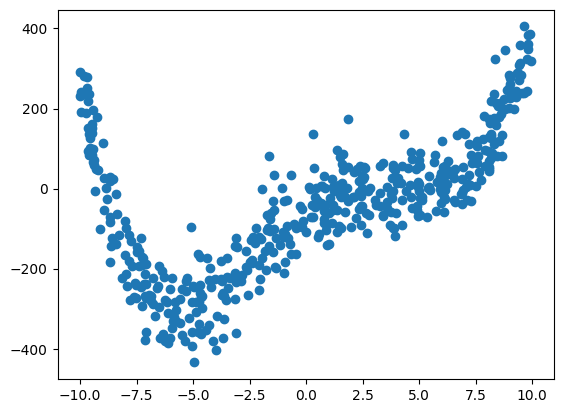

499


In [20]:

np.random.seed(1)
X= [np.random.uniform(-10,10) for _ in range(1, 500)]
X=torch.tensor(X,dtype=torch.float32)
Y =[0.1*(value+9)*((value-4)**3) for value in X]

Y_gauss = Y+np.random.normal(0, 60, 499)
Y_gauss = torch.tensor(Y_gauss,dtype=torch.float32)
plt.plot(X,Y_gauss,'o')
plt.show()
print(len(X))

In [21]:
X=X.unsqueeze(1)
Y_gauss = Y_gauss.unsqueeze(1)

In [22]:
#dataset tensor로 변환
X_train, X_test, y_train, y_test = train_test_split(X,Y_gauss, test_size=0.6, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size=0.5, random_state=42)
#dataset 나누기
print("train:", len(X_train))
print("test:", len(X_test))
print("val:", len(X_valid))

train: 199
test: 150
val: 150


### 2) Dataset Reduction

In [23]:
X_train_list = {}
y_train_list = {}
X_train_list[0], X_trash, y_train_list[0], y_trash = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train_list[1], X_trash, y_train_list[1], y_trash = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_list[2], X_trash, y_train_list[2], y_trash = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
X_train_list[3], X_trash, y_train_list[3], y_trash = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
X_train_list[4], X_trash, y_train_list[4], y_trash = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
X_train_list[5], X_trash, y_train_list[5], y_trash = train_test_split(X_train, y_train, test_size=0.6, random_state=42)
X_train_list[6], X_trash, y_train_list[6], y_trash = train_test_split(X_train, y_train, test_size=0.7, random_state=42)
X_train_list[7], X_trash, y_train_list[7], y_trash = train_test_split(X_train, y_train, test_size=0.8, random_state=42)
X_train_list[8], X_trash, y_train_list[8], y_trash = train_test_split(X_train, y_train, test_size=0.9, random_state=42)
X_train_list[9], X_trash, y_train_list[9], y_trash = train_test_split(X_train, y_train, test_size=0.970, random_state=42)
X_train_list[10], X_trash, y_train_list[10], y_trash = train_test_split(X_train, y_train, test_size=0.75, random_state=42)

#0은 180, 1은 160, ... , 8은 20개, 9는 5개, 10은 50개 이런식으로 원하는 num of reduction 만큼 선택하면 된다.

In [25]:
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_valid, y_valid)

In [26]:
num = 10 #0~8 각각 180~20, 9는 5, 10은 50개를 의미한다.
train_dataset = TensorDataset(X_train_list[num], y_train_list[num])

In [27]:
dataloaders = {}
dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders['val'] = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#3. Training with reduced samples

### 1) Define Model

In [28]:
class DNN(nn.Module):
  def __init__(self, input_size=1, output_size=1, hidden_units=30, num_hidden_layers=3):
    super(DNN, self).__init__()
    self.input = nn.Linear(input_size, hidden_units)

    self.hidden = nn.ModuleList()
    for _ in range(num_hidden_layers):
        self.hidden.append(nn.Linear(hidden_units, hidden_units))

    self.output = nn.Linear(hidden_units, output_size)

  def forward(self, x):
    x = torch.relu(self.input(x))
    for pre_act in self.hidden:
      x = torch.relu(pre_act(x))
    x = self.output(x)
    return x

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 2) Training

In [30]:
test_loss_history = {}
train_loss_history = {}

def train_loop(dataloader, model, loss_fn, optimizer,i):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            if i not in train_loss_history: train_loss_history[i] = []
            train_loss_history[i].append(loss)
            print(f"Training Loss: {loss:>7f}")


def test_loop(dataloader, model, loss_fn,i):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    if i not in test_loss_history: test_loss_history[i] = []
    test_loss_history[i].append(test_loss)
    print(f"Test Loss(Avg.): {test_loss:>8f} \n")

In [31]:
model = {}
for i in range (2,3):
  i = 2
  print("# of hidden layer: ", i)
  model[i] = DNN(num_hidden_layers=i).to(device)
  loss_func = nn.MSELoss()
  optimizer= torch.optim.Adam(model[i].parameters(), lr=learning_rate)

  for t in range(epochs):
      print(f"Epoch {t+1}")
      train_loop(dataloaders['train'], model[i], loss_func, optimizer,i)
      test_loop(dataloaders['val'], model[i], loss_func,i)

      print(f"---------------------\n")
  print("Done!")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Epoch 2168
Training Loss: 2605.272217
Test Loss(Avg.): 4356.966797 

---------------------

Epoch 2169
Training Loss: 2605.509766
Test Loss(Avg.): 4351.428345 

---------------------

Epoch 2170
Training Loss: 2606.209717
Test Loss(Avg.): 4353.488037 

---------------------

Epoch 2171
Training Loss: 2604.702881
Test Loss(Avg.): 4360.177490 

---------------------

Epoch 2172
Training Loss: 2604.971436
Test Loss(Avg.): 4353.793823 

---------------------

Epoch 2173
Training Loss: 2604.334229
Test Loss(Avg.): 4348.921631 

---------------------

Epoch 2174
Training Loss: 2604.232666
Test Loss(Avg.): 4353.617310 

---------------------

Epoch 2175
Training Loss: 2603.865479
Test Loss(Avg.): 4352.439575 

---------------------

Epoch 2176
Training Loss: 2603.722412
Test Loss(Avg.): 4345.626709 

---------------------

Epoch 2177
Training Loss: 2604.786621
Test Loss(Avg.): 4357.420410 

---------------------

Epoch 2178
Training Loss: 2603.793945
Test 

### 3) Learning Curve

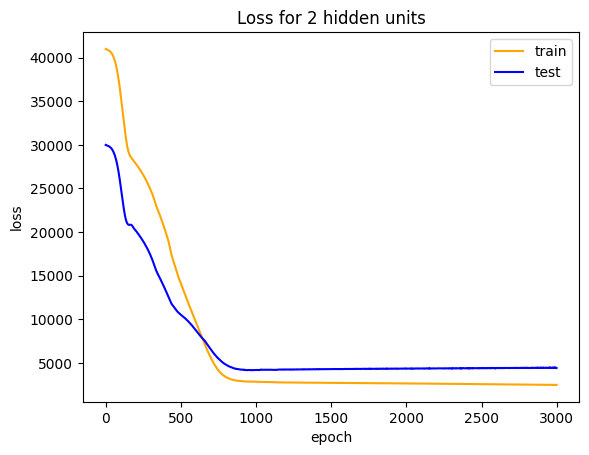

Final Test Loss for 2:  4406.535888671875


In [32]:
i = 2
plt.plot(train_loss_history[i], label='train', color = 'orange')
plt.plot(test_loss_history[i], label='test', color = 'blue')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'Loss for {i} hidden units')
plt.legend()
plt.show()
capacity_loss = {}

for i in range(2,3):
  print(f"Final Test Loss for {i}: ", test_loss_history[i][-1])
  capacity_loss[i] = test_loss_history[i][-1]

### 4) True function vs Model Prediction

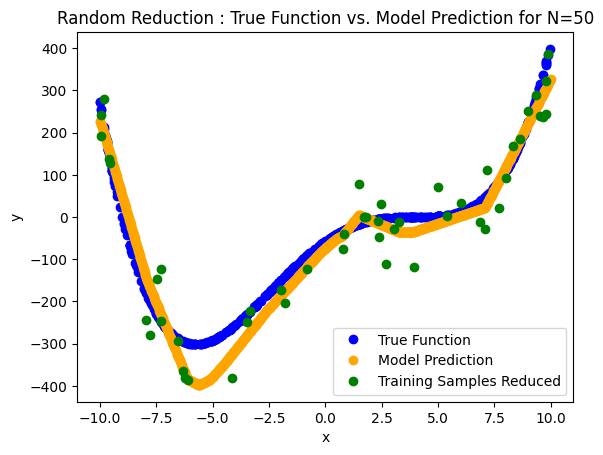

In [33]:
x = torch.linspace(-10, 10, 1000).unsqueeze(1)

i = 2
plt.plot(X, Y, 'o', label='True Function', color = 'blue')
plt.plot(x, model[i](x).detach().numpy(),'o', label='Model Prediction', color = 'orange')
plt.plot(X_train_list[10], y_train_list[10], 'o', label = 'Training Samples Reduced', color = 'green')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Random Reduction : True Function vs. Model Prediction for N=50')
plt.legend()
plt.show()

### 5) Model Selection

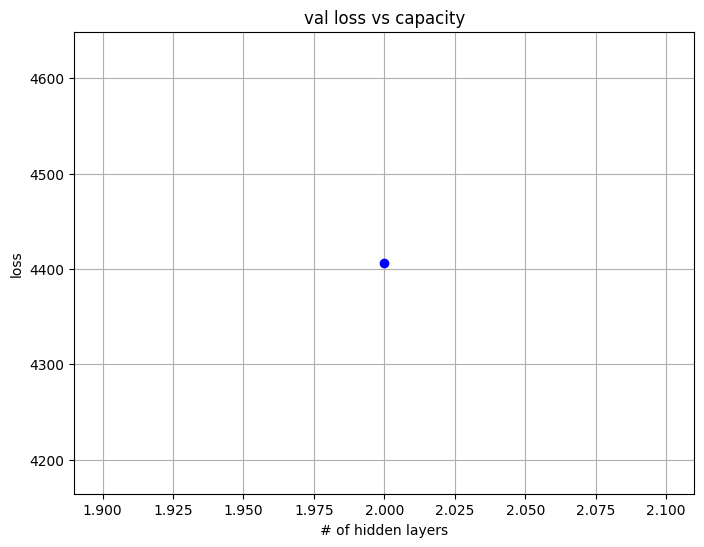

In [34]:
  ### Capacity - Loss

keys = list(capacity_loss.keys())
values = list(capacity_loss.values())
keys_tensor = torch.tensor(keys, dtype=torch.float32)
values_tensor = torch.tensor(values, dtype=torch.float32)

plt.figure(figsize=(8, 6))
plt.plot(keys_tensor.numpy(), values_tensor.numpy(), marker='o', linestyle='-', color='b')
plt.xlabel('# of hidden layers')
plt.ylabel('loss')
plt.title('val loss vs capacity')
plt.grid(True)
plt.show()

### 6) Results

In [35]:
#validation set에 대한 최적의 #of hidden layer 결정
#그 model에 대한 test loss 계산하기
def final_test_loss(dataloader, model, loss_fn,i):
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Final Test Loss(Avg.): {test_loss:>8f} \n")

min_val_loss = min_key = min(capacity_loss.values())
optimal_i = min_key = min(capacity_loss, key=capacity_loss.get)
print("minimum validation loss: ", min_val_loss, "optimal_i:", optimal_i)
final_test_loss(dataloaders['test'], model[optimal_i], loss_func,i)

minimum validation loss:  4406.535888671875 optimal_i: 2
Final Test Loss(Avg.): 5550.310791 

